# Precursor mass differences

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
import collections

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import tqdm

from ann_solo import reader

In [3]:
tqdm.tqdm = tqdm.tqdm_notebook

# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

In [4]:
psms_dir = '../data/processed/hek293/ann-solo/oms'

In [5]:
psms = []
for filename in tqdm.tqdm(os.listdir(os.path.join(psms_dir)),
                          'Files processed', unit='files'):
    if filename.endswith('.mztab'):
        psms.append(reader.read_mztab_psms(os.path.join(psms_dir, filename)))

psms = pd.concat(psms)

HBox(children=(IntProgress(value=0, description='Files processed: ', max=49), HTML(value='')))

In [6]:
psms['mass_diff'] = (
    (psms['exp_mass_to_charge'] - psms['calc_mass_to_charge']) * psms['charge']
)

In [7]:
tol_mass = 0.1
tol_mode = 'Da'

In [8]:
# start with the highest ranked PSM
mass_groups = []
psms_remaining = psms
while len(psms_remaining) > 0:
    # find all remaining PSMs within the precursor mass window
    mass_diff = psms_remaining['mass_diff'].iloc[0]
    if tol_mass is None or tol_mode not in ('Da', 'ppm'):
        psms_selected = psms_remaining
    elif tol_mode == 'Da':
        psms_selected = \
            psms_remaining[(psms_remaining['mass_diff'] - mass_diff).abs()
                           <= tol_mass]
    elif tol_mode == 'ppm':
        psms_selected = \
            psms_remaining[(psms_remaining['mass_diff'] - mass_diff).abs()
                           / psms_remaining['exp_mass_to_charge'] * 10 ** 6
                           <= tol_mass]
    mass_groups.append(psms_selected)
    # exclude the selected PSMs from further selections
    psms_remaining.drop(psms_selected.index, inplace=True)

mass_group_stats = []
for mass_group in mass_groups:
    mass_group_stats.append((mass_group['mass_diff'].median(),
                             mass_group['mass_diff'].mean(),
                             len(mass_group)))
mass_group_stats = pd.DataFrame.from_records(
    mass_group_stats, columns=['mass_diff_median', 'mass_diff_mean', 'num_psms'])

In [9]:
mass_group_stats.sort_values('num_psms', ascending=False).head(10)

,mass_diff_median,mass_diff_mean,num_psms
1,0.002580,0.002525,369341
3,1.005409,1.000509,46659
10,15.997952,15.998286,31473
33,2.006034,1.996613,14088
47,-0.991490,-0.989924,6418
42,-17.023168,-17.020997,5777
153,17.002129,17.007212,5433
61,183.038634,183.038338,4815
15,27.998370,28.002045,4777
233,301.990756,301.992218,3266


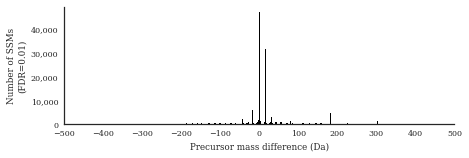

In [10]:
width = 7
height = width / 1.618 / 2
fig, ax = plt.subplots(figsize=(width, height))

mask = mass_group_stats['mass_diff_median'].abs() > tol_mass   # exclude unmodified PSMs
ax.bar(mass_group_stats[mask]['mass_diff_median'],
       mass_group_stats[mask]['num_psms'],
       width=1, log=False, color='black')

ax.set_xlabel('Precursor mass difference (Da)')
fdr = 0.01    # specified in the search settings
ax.set_ylabel('Number of SSMs\n(FDR={})'.format(fdr))

ax.set_xlim((-500, 500))

# set tick labels at nice positions
ax.xaxis.set_major_locator(mticker.MultipleLocator(100))
# format y-axis numbers
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,g}'))

sns.despine()

plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()